# Span Batch Analysis - Goerli Result Analysis

Get number of channels and each channel names. Channel name must have length 32 in hexadecimal form.

In [1]:
import os
import re

DATA_ROOT_DIR = "./artifacts"
CHAIN_NAME = "goerli"

CHANNEL_CACHE_DIR = f"{DATA_ROOT_DIR}/{CHAIN_NAME}/channel_cache"


def is_hexadecimal(s: str) -> bool:
    hex_pattern = re.compile(r'^[a-fA-F0-9]+$')
    return bool(hex_pattern.match(s))


def read_channel_ids(directory):
    channel_ids = set()
    with os.scandir(directory) as entries:
        for entry in entries:
            assert entry.is_file()
            filename = entry.name
            channel_id, ext = os.path.splitext(filename)
            assert ext == ".json" and len(channel_id) == 32 and is_hexadecimal(channel_id)
            channel_ids.add(channel_id)
    return channel_ids

channel_ids = read_channel_ids(CHANNEL_CACHE_DIR)
channel_id_count = len(channel_ids)
print(f"Number of channels: {channel_id_count}")


Number of channels: 2467


Sanity check of results. Number of jsons in each result directory must be equal to number of channels.

In [2]:
SPAN_BATCH_CACHE_V1_DIR = f"{DATA_ROOT_DIR}/{CHAIN_NAME}/span_batch_cache_v1"
SPAN_BATCH_CACHE_V2_DIR = f"{DATA_ROOT_DIR}/{CHAIN_NAME}/span_batch_cache_v2"
SPAN_BATCH_CACHE_V3_DIR = f"{DATA_ROOT_DIR}/{CHAIN_NAME}/span_batch_cache_v3"
SPAN_BATCH_CACHE_DIRS = [SPAN_BATCH_CACHE_V1_DIR, SPAN_BATCH_CACHE_V2_DIR, SPAN_BATCH_CACHE_V3_DIR]

for directory in SPAN_BATCH_CACHE_DIRS:
    temp_channel_ids = read_channel_ids(directory) 
    assert temp_channel_ids == channel_ids, (len(temp_channel_ids), len(channel_ids))

Relation between `UncompressedSizeReductionPercent` and `SpanBatchMetadataSizePercent`. They should be proportional.

`SpanBatchMetadataSizePercent` := `100 * SpanBatchMetadataSize / SpanBatchSize`


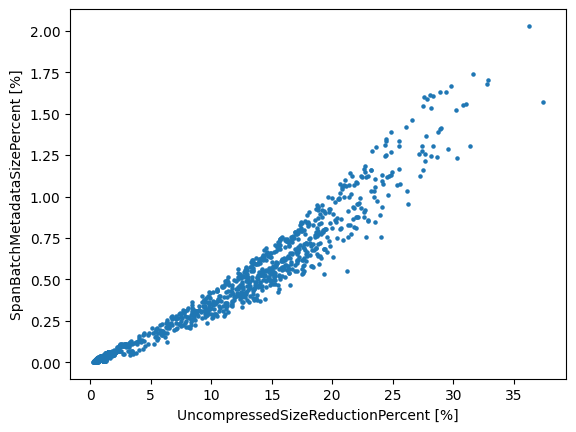

In [31]:
import matplotlib.pyplot as plt
import random
import json

RESULT_V1_DIR = f"{DATA_ROOT_DIR}/{CHAIN_NAME}/result_v1"
RESULT_V2_DIR = f"{DATA_ROOT_DIR}/{CHAIN_NAME}/result_v2"
RESULT_V3_DIR = f"{DATA_ROOT_DIR}/{CHAIN_NAME}/result_v3"
RESULT_DIRS = [RESULT_V1_DIR, RESULT_V2_DIR, RESULT_V3_DIR]

DIR = RESULT_V3_DIR

Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            uncompressed_reduction_precent = result["UncompressedSizeReductionPercent"]
            Xs.append(uncompressed_reduction_precent)
            metadata_size = result["SpanBatchMetadataSize"]
            tx_size = result["SpanBatchTxSize"]
            metadata_percent = metadata_size / (metadata_size + tx_size) * 100
            Ys.append(metadata_percent)

plt.scatter(Xs, Ys, s=5)
plt.xlabel("UncompressedSizeReductionPercent [%]")
plt.ylabel("SpanBatchMetadataSizePercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Sample single channel and observe span batch results.

In [15]:
channel_id = random.choice(list(channel_ids))

results = []
for dir in RESULT_DIRS:
    filename = f"{dir}/{channel_id}.json"
    with open(filename) as f:
        result = json.load(f)
        results.append(result)
        print(result)

{'FrameCount': 2, 'BatchV1sCompressedSize': 148420, 'BatchV1sUncompressedSize': 274026, 'BatchV1sCompressionRatio': 0.5416274368125652, 'SpanBatchCompressedSize': 146904, 'SpanBatchUncompressedSize': 271915, 'SpanBatchCompressionRatio': 0.5402570656271262, 'BatchV1sMetadataSize': 2104, 'BatchV1sTxSize': 271922, 'SpanBatchMetadataSize': 78, 'SpanBatchTxSize': 271837, 'SpanBatchPrefixSize': 48, 'SpanBatchPayloadSize': 271867, 'CompressedReductionPercent': 1.021425683870103, 'UncompressedSizeReductionPercent': 0.7703648558895826, 'L2TxCount': 39, 'L1StartNum': 9463690, 'L1EndNum': 9463694, 'L1BlockCount': 5, 'L2StartNum': 12882067, 'L2EndNum': 12882091, 'L2BlockCount': 25}
{'FrameCount': 2, 'BatchV1sCompressedSize': 148420, 'BatchV1sUncompressedSize': 274026, 'BatchV1sCompressionRatio': 0.5416274368125652, 'SpanBatchCompressedSize': 147048, 'SpanBatchUncompressedSize': 272118, 'SpanBatchCompressionRatio': 0.540383216104778, 'BatchV1sMetadataSize': 2104, 'BatchV1sTxSize': 271922, 'SpanBatc

Plots before compression.

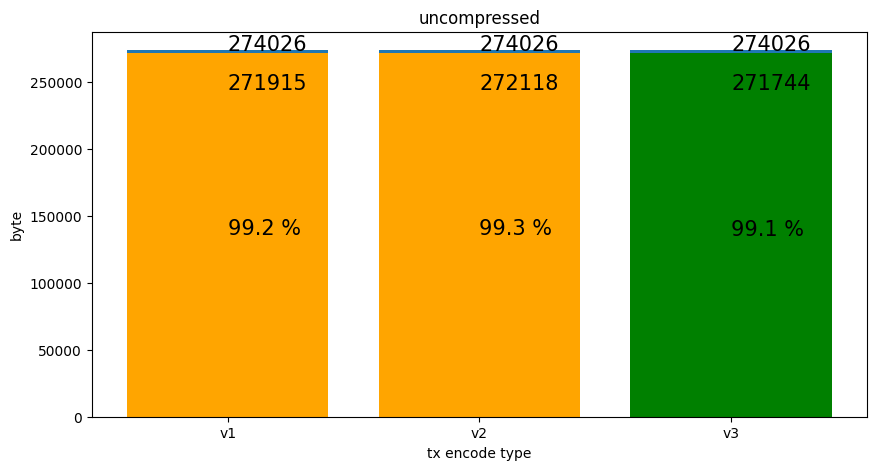

In [16]:
index = [f"v{i + 1}" for i in range(3)]
data_batchV0 = {
    f"v{i + 1}": results[i]["BatchV1sUncompressedSize"] for i in range(3)
}
data_spanbatch = {
    f"v{i + 1}": results[i]["SpanBatchUncompressedSize"] for i in range(3)
}
data_reduction_percent = {
    f"v{i + 1}": results[i]["UncompressedSizeReductionPercent"] for i in range(3)
}

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.bar(x=index, height=data_batchV0.values(), align="center")
for key, value in data_batchV0.items():
    plt.text(x=key, y=value+1, s=f"{value}", fontdict=dict(fontsize=15))

# indicate best tx encoding as green
colors = ["orange" for _ in index]
min_idx = list(data_reduction_percent.values()).index(max(data_reduction_percent.values()))
colors[min_idx] = "green"

ax.bar(x=index, height=data_spanbatch.values(), align="center", color=colors)
for key, value in data_spanbatch.items():
    plt.text(x=key, y=value * 0.9, s=f"{value}", fontdict=dict(fontsize=15))
    percentage = f"{str(100 - data_reduction_percent[key])[:4]} %"
    plt.text(x=key, y=value // 2, s=percentage, fontdict=dict(fontsize=15))

plt.xlabel("tx encode type")
plt.ylabel("byte")
plt.title("uncompressed")
plt.show()

Plots after compression.

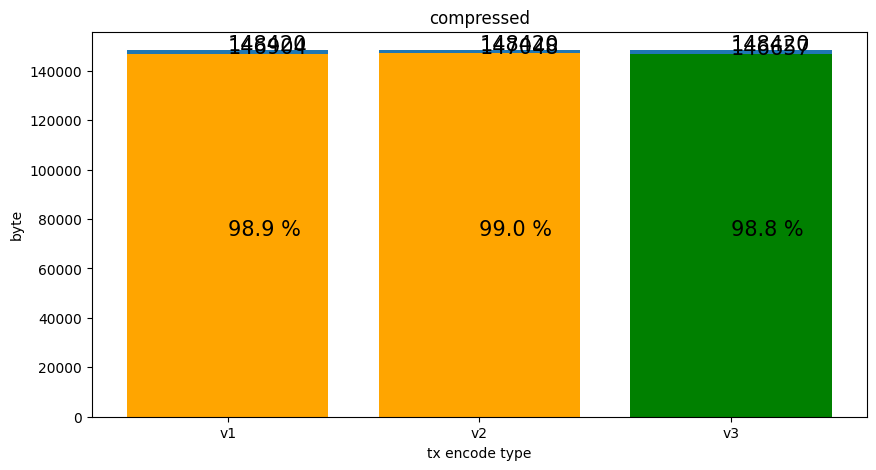

In [32]:
import matplotlib.pyplot as plt
 
index = [f"v{i + 1}" for i in range(3)]
data_batchV0 = {
    f"v{i + 1}": results[i]["BatchV1sCompressedSize"] for i in range(3)
}
data_spanbatch = {
    f"v{i + 1}": results[i]["SpanBatchCompressedSize"] for i in range(3)
}
data_reduction_percent = {
    f"v{i + 1}": results[i]["CompressedReductionPercent"] for i in range(3)
}

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.bar(x=index, height=data_batchV0.values(), align="center")
for key, value in data_batchV0.items():
    plt.text(x=key, y=value+1, s=f"{value}", fontdict=dict(fontsize=15))

# indicate best tx encoding as green
colors = ["orange" for _ in index]
min_idx = list(data_reduction_percent.values()).index(max(data_reduction_percent.values()))
colors[min_idx] = "green"

ax.bar(x=index, height=data_spanbatch.values(), align="center", color=colors)
for key, value in data_spanbatch.items():
    plt.text(x=key, y=value+1, s=f"{value}", fontdict=dict(fontsize=15))
    percentage = f"{str(100 - data_reduction_percent[key])[:4]} %"
    plt.text(x=key, y=value // 2, s=percentage, fontdict=dict(fontsize=15))

plt.xlabel("tx encode type")
plt.ylabel("byte")
plt.title("compressed")
plt.show()